In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Чтение данных и разбиение на тестовую и обучающую выборку в соотношении 3:7


In [2]:
from google.colab import files
uploaded = files.upload()

Saving data.json to data.json


In [3]:
with open('data.json', 'r') as f:
  data = json.load(f)

In [4]:
df = pd.DataFrame(data)
df = df.set_index(['id'])

In [5]:
df.sample(3)

,cuisine,ingredients
id,,
19779,mexican,"[black beans, sweet potatoes, salt, ground cum..."
46272,southern_us,"[baking soda, coarse kosher salt, melted butte..."
23246,irish,"[water, cabbage, garlic, potatoes, corned beef..."


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
mlb = MultiLabelBinarizer()

In [8]:
df_encoded = pd.DataFrame(mlb.fit_transform(df['ingredients']), columns=mlb.classes_, index=df.index)

# Объединение новых признаков с исходным датафреймом
df = pd.concat([df, df_encoded], axis=1)

In [9]:
train, test = train_test_split(df, test_size=0.3, random_state=29)

### Анализ датасета с графиками


In [10]:
def popular_cuisine_ingredients(df, top_n = 10):
  cuisine_dict = {}
  for _, row in df.iterrows():
    cuisine = row['cuisine']
    ingredients = row['ingredients']
    if cuisine not in cuisine_dict:
      cuisine_dict[cuisine] = {}
    for ingredient in ingredients:
      if ingredient not in cuisine_dict[cuisine]:
        cuisine_dict[cuisine][ingredient] = 1
      else:
        cuisine_dict[cuisine][ingredient] += 1

  unique_cuisines = list(cuisine_dict.keys())
  num_cuisines = len(unique_cuisines)

  fig, axes = plt.subplots(int(np.ceil(num_cuisines/2)), 2, figsize=(18, 2 * num_cuisines))
  for idx, cuisine in enumerate(unique_cuisines):
    d = {k: v for k, v in sorted(cuisine_dict[cuisine].items(), key=lambda item: item[1])}
    ingredients_top_n = list(d.keys())[-top_n:][::-1]
    counts_top_n = list(d.values())[-top_n:][::-1]
    axes[idx//2, idx%2].barh(ingredients_top_n, counts_top_n)
    axes[idx//2, idx%2].set_title(f'Popular ingredients in {cuisine} cuisine')

  plt.show()

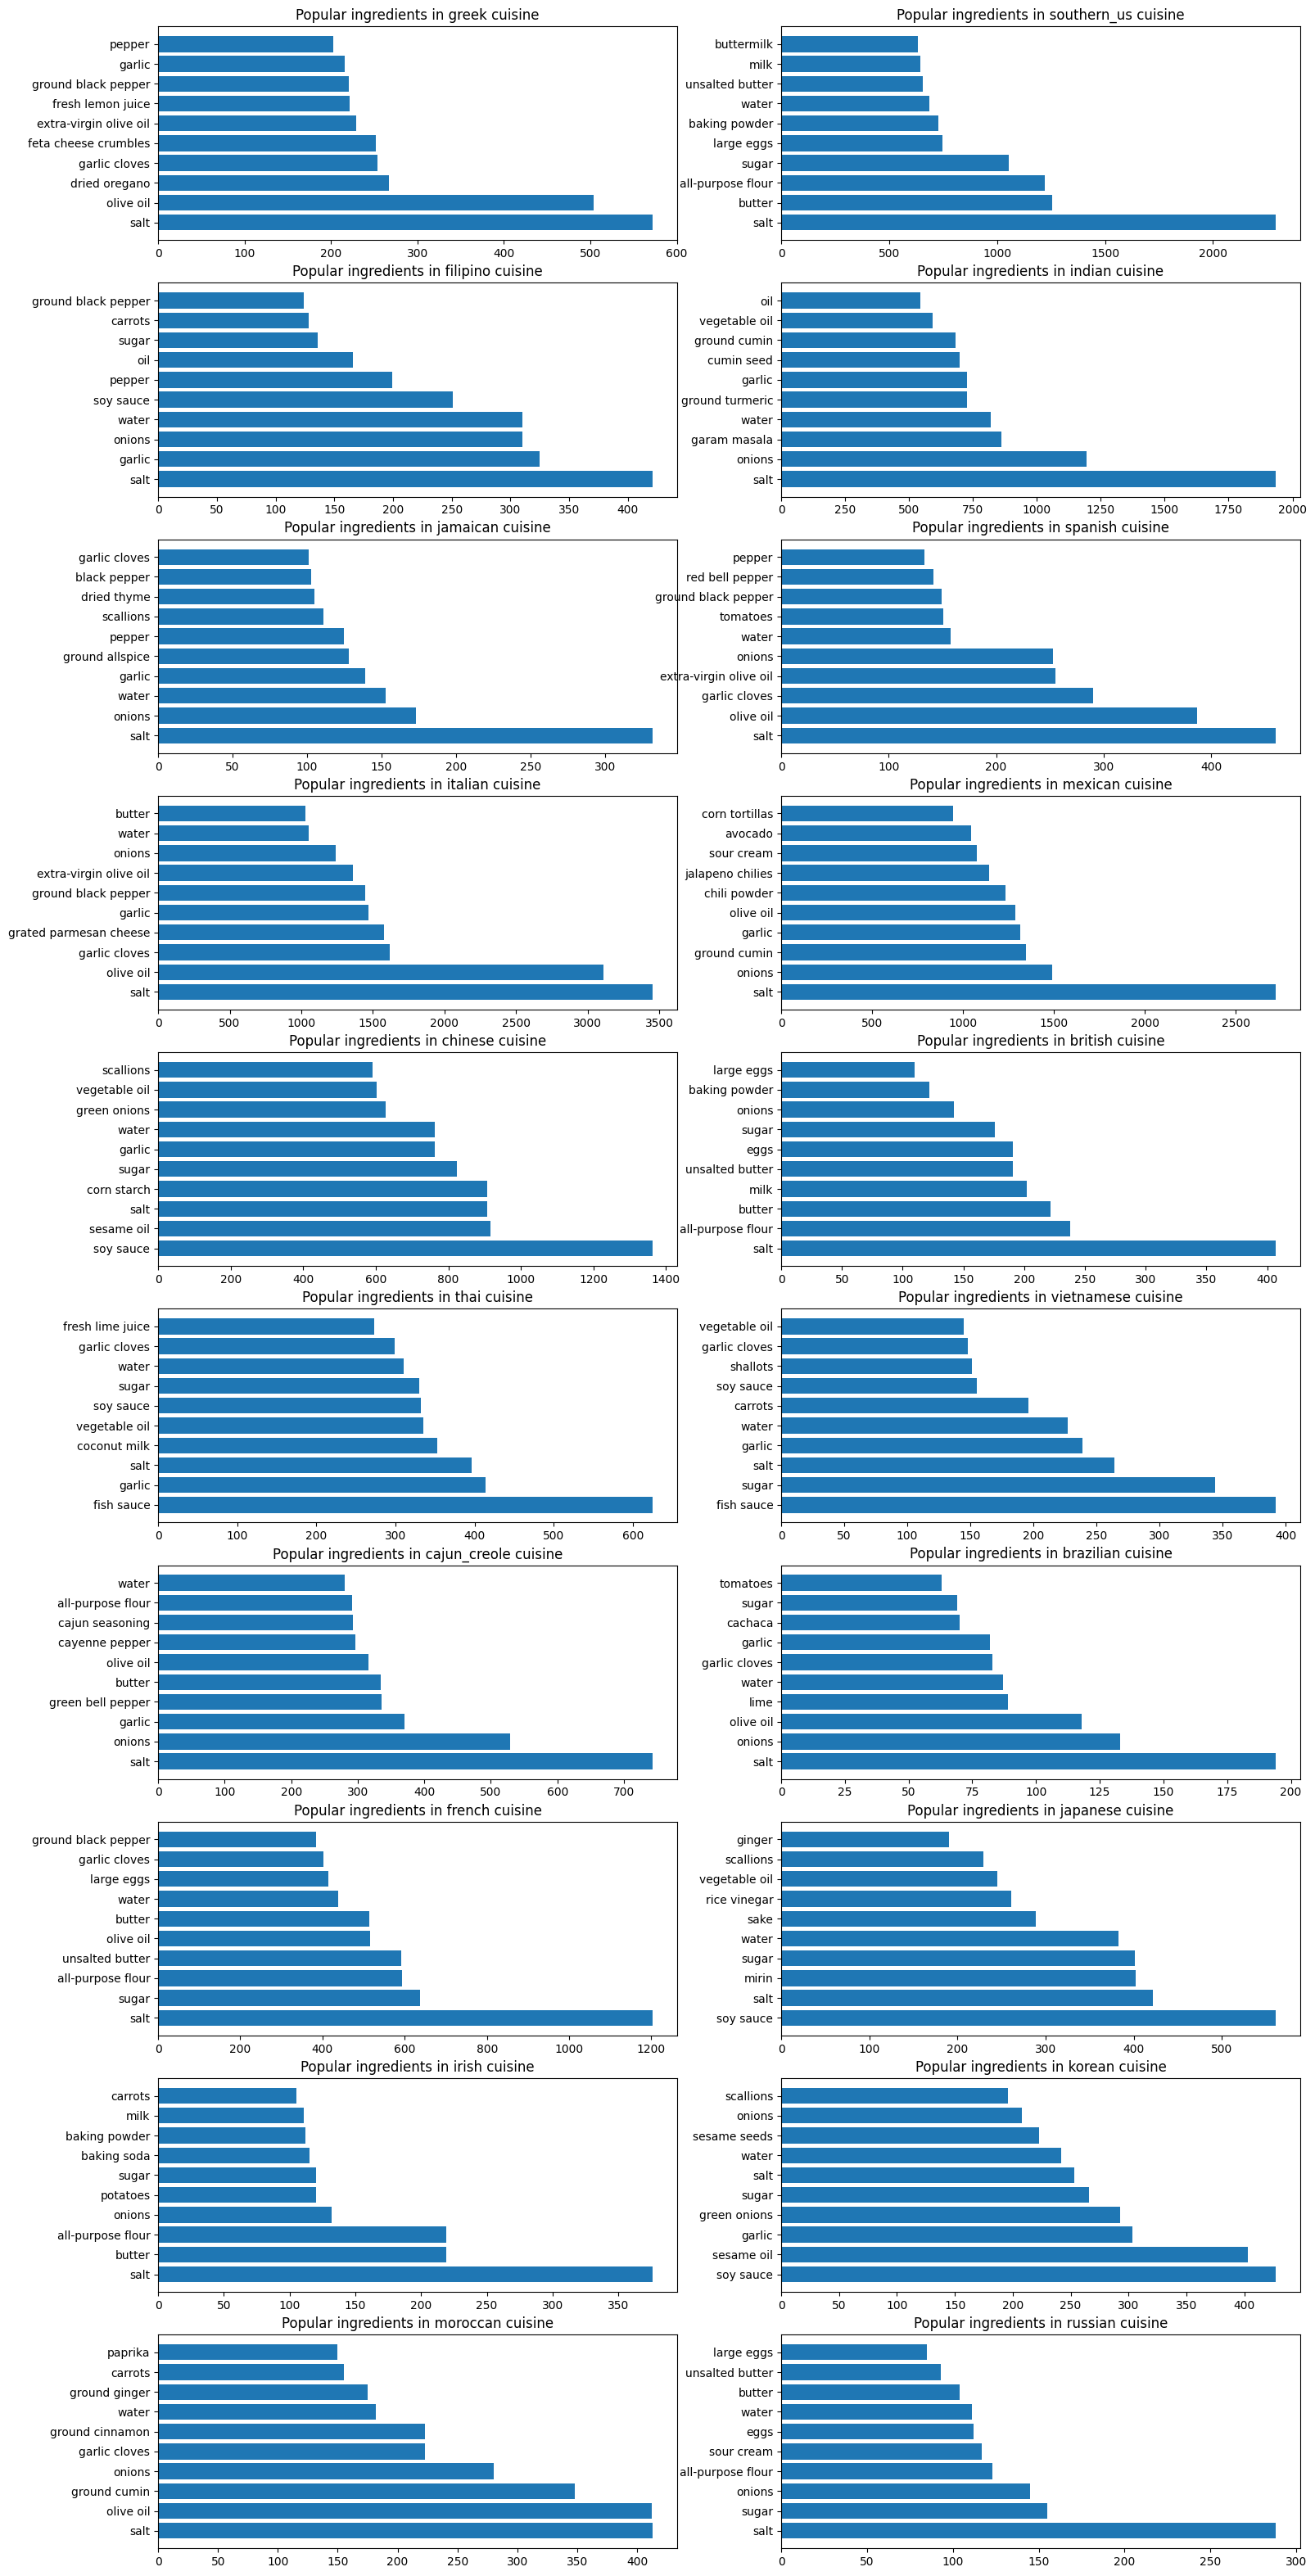

In [11]:
popular_cuisine_ingredients(df)

Видим, что во всех кухнях встречается часто вода, соль и сахар.

Уже заметны характерные признаки некоторых кухонь, например рисовый уксус в японской кухне или соевый соус в корейской.

In [12]:
def avg_number_ingredients(df):
  count = {}
  for _, row in df.iterrows():
    cuisine = row['cuisine']
    ingredients = row['ingredients']
    if cuisine not in count:
      count[cuisine] = []
    count[cuisine].append(len(ingredients))

  # cuisines = []
  # avg_ingredients = []
  # for cuisine, counts in count.items():
  #   cuisines.append(cuisine)
  #   avg_ingredients.append(np.mean(counts))

  # sns.axlabel(xlabel="Count", ylabel="Cuisine", fontsize=16)
  plt.figure(figsize=(18, 10))
  sns.boxplot(data=list(count.values()))

  plt.xticks(plt.xticks()[0], list(count.keys()))
  plt.ylabel('Number of ingredients')
  plt.show()

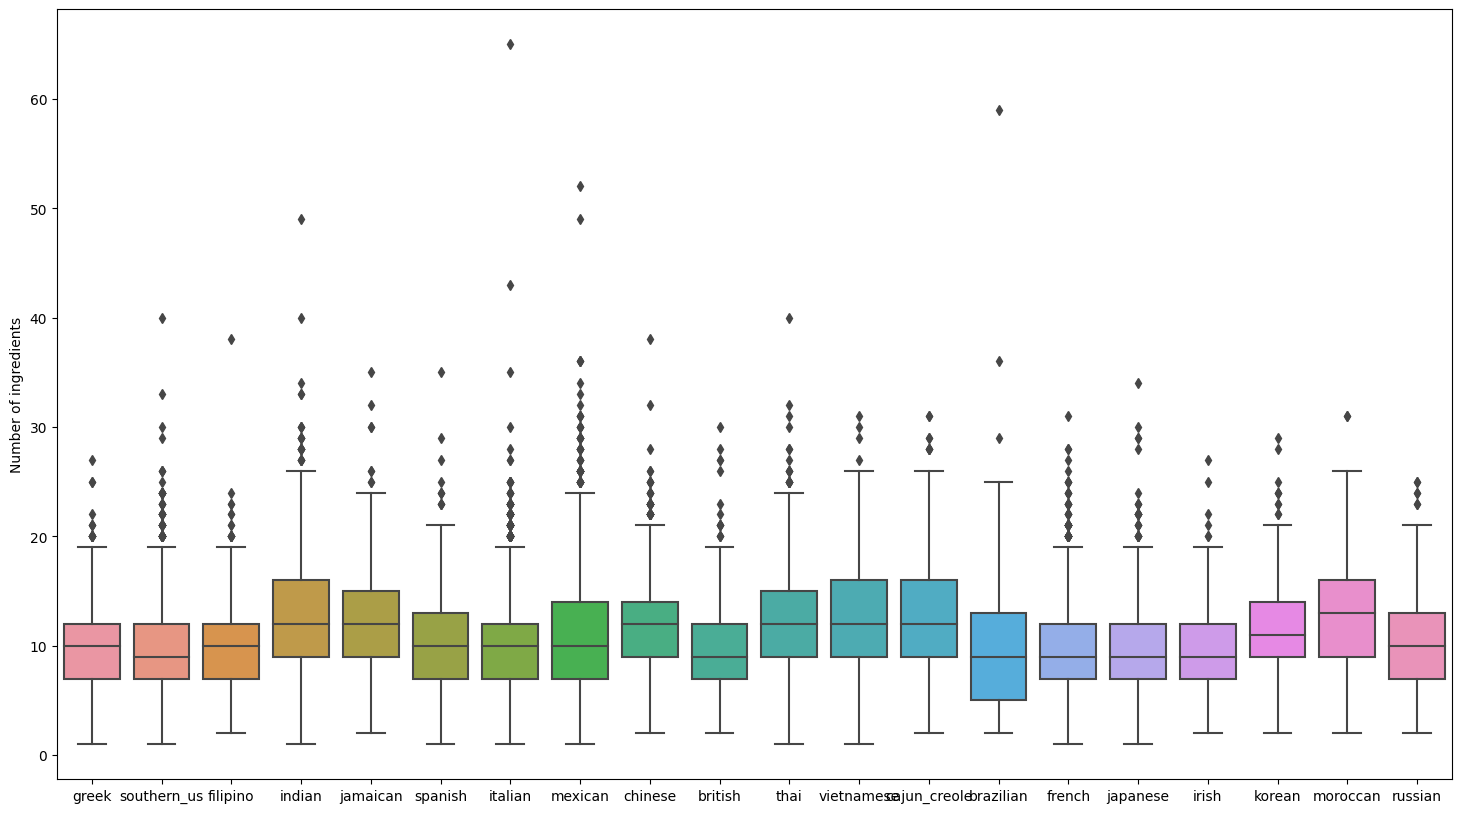

In [13]:
avg_number_ingredients(df)

Видим, что в целом среднее количество ингридиентов в разных кухнях одинаково, хоть и есть выбросы.

### Выбор признаков и их кодирование


In [14]:
# уберем признак со списком ингридиентов, так как теперь у нас есть новые более подходящие для обучения признаки
X_train = train.drop(['ingredients', 'cuisine'], axis=1)
X_test = test.drop(['ingredients', 'cuisine'], axis=1)

In [15]:
y_train = train['cuisine']
y_test = test['cuisine']

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
label_encoder = LabelEncoder()

In [18]:
# для работы некоторых моделей требуется чтобы лейблы классов были числовыми (int)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

### Обучение нескольких моделей и подбор гиперпараметров. Подсчет метрик. Анализ результатов

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [23]:
# Попробуем использовать решающие деревья

tree_params = {'max_depth': [None, 5, 10],
               'min_samples_leaf' : [10, 20]
               }
tree_clf = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree_clf, tree_params, cv=5, scoring='accuracy', verbose=5)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_depth=None, min_samples_leaf=10;, score=0.573 total time=  27.6s
[CV 2/5] END max_depth=None, min_samples_leaf=10;, score=0.584 total time=  21.4s
[CV 3/5] END max_depth=None, min_samples_leaf=10;, score=0.578 total time=  21.2s
[CV 4/5] END max_depth=None, min_samples_leaf=10;, score=0.582 total time=  20.2s
[CV 5/5] END max_depth=None, min_samples_leaf=10;, score=0.575 total time=  20.6s
[CV 1/5] END max_depth=None, min_samples_leaf=20;, score=0.551 total time=  18.7s
[CV 2/5] END max_depth=None, min_samples_leaf=20;, score=0.563 total time=  18.0s
[CV 3/5] END max_depth=None, min_samples_leaf=20;, score=0.557 total time=  18.9s
[CV 4/5] END max_depth=None, min_samples_leaf=20;, score=0.555 total time=  17.6s
[CV 5/5] END max_depth=None, min_samples_leaf=20;, score=0.557 total time=  19.0s
[CV 1/5] END ..max_depth=5, min_samples_leaf=10;, score=0.303 total time=   3.7s
[CV 2/5] END ..max_depth=5, min_samples

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [10, 20]},
             scoring='accuracy', verbose=5)

In [24]:
tree_best_params = tree_grid.best_params_
tree_model = tree_grid.best_estimator_
tree_pred = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_pred)
print(f"Decision Tree Accuracy: {tree_accuracy:.4f}, Best Params: {tree_best_params}")

Decision Tree Accuracy: 0.5866, Best Params: {'max_depth': None, 'min_samples_leaf': 10}


Получили лучший скор Accuracy, равный 0.5866 при параметрах Best Params. В целом это достаточно неплохой результат, для его улучшения можно попробовать увеличить сетку гиперпараметров.

In [ ]:
# И еще попробуем логистическую регрессию (LR)
LR_params = {'tol': [0.0001, 0.001, 0.01],
              'C': [0.1, 1, 2]
              }
LR_clf = LogisticRegression()
LR_grid = GridSearchCV(LR_clf, LR_params, cv=5, scoring='accuracy', verbose=10)
LR_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START C=0.1, tol=0.0001...........................................
[CV 1/5; 1/9] END ............C=0.1, tol=0.0001;, score=0.734 total time= 2.4min
[CV 2/5; 1/9] START C=0.1, tol=0.0001...........................................


In [ ]:
LR_best_params = LR_grid.best_params_
LR_model = LR_grid.best_estimator_
LR_pred = LR_model.predict(X_test)
LR_accuracy = accuracy_score(y_test, LR_pred)
print(f"Logistic Regression Accuracy: {LR_accuracy:.4f}, Best Params: {LR_best_params}")